In [1]:
from __future__ import print_function

import os
import cv2
import numpy as np
import re
import csv
from PIL import Image
import PIL.ImageOps
from matplotlib import pyplot

import tensorflow
import tensorflow.keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D
from math import hypot

import numba
from numba import jit, cuda, vectorize


tensorflow.config.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

gpu_devices = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(gpu_devices[0], True)
#print("GPUs: " + gpu_devices[0])

gpus = tensorflow.test.gpu_device_name()
print("GPUs: " + gpus)

GPUs: /device:GPU:0


In [2]:
folders = []
path = os.getcwd() + "\Allframedata"

obj = os.scandir(os.getcwd() + "\Allframedata") 
print("Files and Directories in '% s'" % path) 

for entry in obj : 
    if entry.is_dir() or entry.is_file():
        folders.append(entry.name)

Files and Directories in 'C:\Users\main\Allframedata'


In [3]:
def rotate(image, angle=90, scale=1.0):
        '''
        Rotate the image
        :param image: image to be processed
        :param angle: Rotation angle in degrees. 
                      Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
        :param scale: Isotropic scale factor.
        '''
        w = image.shape[1]
        h = image.shape[0]
        #rotate matrix
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
        #rotate
        image = cv2.warpAffine(image,M,(w,h))
        return image
    
def flip(image, vflip=False, hflip=False):
        '''
        Flip the image
        :param image: image to be processed
        :param vflip: whether to flip the image vertically
        :param hflip: whether to flip the image horizontally
        '''
        if hflip or vflip:
            if hflip and vflip:
                c = -1
            else:
                c = 0 if vflip else 1
            image = cv2.flip(image, flipCode=c)
        return image 
    
def new_editor(directory, img):
    #                 CROP
    #decreasing y_start decreases y_end
    x_start = 55
    y_start = 50
    crop_img = img[y_start:y_start+1255, x_start:x_start+1245]

    #                 RESIZE CROPPED
    scale_percent = 50
    width = int(crop_img.shape[1] * scale_percent / 100)
    height = int(crop_img.shape[0] * scale_percent / 100)
    dsize = (width, height)
    img = cv2.resize(crop_img, dsize)

    #                 MASK
    editedImg = np.where(img < 180, img, 0)
    
    return editedImg

'''
ex_path = path + "\\" + folders[0] + "\\" + "PRT_000001_L1.jpg"
img2 = cv2.imread(ex_path, 0)
#np.set_printoptions(threshold=sys.maxsize)
#print(img2)
img2 = new_editor(ex_path, img2)

print("img2shape", img2.shape)
'''

'\nex_path = path + "\\" + folders[0] + "\\" + "PRT_000001_L1.jpg"\nimg2 = cv2.imread(ex_path, 0)\n#np.set_printoptions(threshold=sys.maxsize)\n#print(img2)\nimg2 = new_editor(ex_path, img2)\n\nprint("img2shape", img2.shape)\n'

In [4]:
@jit
def old_mask(directory):

    img = cv2.imread(directory)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #img_copy = img.copy()
    #pyplot.imshow(img, cmap=pyplot.cm.binary)

    #                 CROP
    #decreasing y_start decreases y_end
    x_start = 55
    y_start = 50
    crop_img = img[y_start:y_start+1255, x_start:x_start+1245]

    #                 RESIZE CROPPED
    scale_percent = 50
    width = int(crop_img.shape[1] * scale_percent / 100)
    height = int(crop_img.shape[0] * scale_percent / 100)
    dsize = (width, height)
    img = cv2.resize(crop_img, dsize)

    img = cv2.medianBlur(img,5)
    #cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 400, param1=50, param2=25, minRadius=150, maxRadius=0)

    circles = np.uint16(np.around(circles))

    x, y, r = circles[0,:][0]
    rows, cols = img.shape

    for i in range(cols):
        for j in range(rows):
            if hypot(i-x, j-y) > r:
                img[j,i] = 0
                
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    #pyplot.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    return img

In [5]:
def edit_csvfiles(directory):
    inputfile = csv.reader(open(directory + '\\DefectResult.csv','r'))
    outputfile = open(directory + '\\DefectResult_edited.csv','w')
    i=0
    for row in inputfile:
        for i in range(0, len(row)):
            if i == 5:
                attributes = row[i].replace('Bottom','Bottom,\n')
                outputfile.write(attributes)
                outputfile.write(",")
                continue
            outputfile.write(row[i])
            outputfile.write(",")
        outputfile.write("\n")

In [6]:
@jit
def load_images_from_folder(folder, key):
    listofFiles = os.listdir(folder)
    
    for filename in listofFiles:
        joinedFilePath = os.path.join(folder,filename)
        if key =="RGB":
            img = cv2.imread(joinedFilePath)
        elif key == "Grayscale":
            img = cv2.imread(joinedFilePath, 0)
        if img is not None and filename == "PRT_000001_L1.jpg":
            mask_path = folder+"\\"+filename
            img = old_mask(mask_path)
            #img = new_editor(mask_path,img)
            print("Masked at", mask_path)
            return img

def get_labels(folder):
    defect = "불량" #2
    reserved = "보류" #1
    normal = "정상" #0
    target = folder + "\\" + 'DefectResult_edited.csv'
    label = "N/A"
    
    if os.path.exists(target):
        with open(target) as fin:
            reader = csv.reader(fin)
            next(reader)
            for row in reader:
                #print(row[1:])
                if defect in row:
                    label = 2
                    break;
                elif reserved in row:
                    label = 1
                elif normal in row:
                    label = 0         
    else:
        print("Defect Results was not found in ", folder)
        
    return label

In [7]:
@jit
def main_operation(path, folders):

    images = []
    labels = []
    folder= path

    for i in range(0, len(folders)):
        folder= path + "\\" + folders[i]
        edit_csvfiles(folder) #run once only
        result = load_images_from_folder(folder, "Grayscale") #choose "RGB" or "Grayscale"
        images.append(result)
        the_label = get_labels(folder)
        labels.append(the_label)
        '''
        if the_label == 1:
            rotated90_img = rotate(result, angle=90, scale=1.0)
            images.append(rotated90_img)
            labels.append(get_labels(folder))

            rotated180_img = rotate(result, angle=180, scale=1.0)
            images.append(rotated180_img)
            labels.append(get_labels(folder))

            rotated270_img = rotate(result, angle=270, scale=1.0)
            images.append(rotated270_img)
            labels.append(get_labels(folder))
        '''
        if the_label == 2:
            rotated90_img = rotate(result, angle=90, scale=1.0)
            images.append(rotated90_img)
            labels.append(get_labels(folder))

            rotated180_img = rotate(result, angle=180, scale=1.0)
            images.append(rotated180_img)
            labels.append(get_labels(folder))

            rotated270_img = rotate(result, angle=270, scale=1.0)
            images.append(rotated270_img)
            labels.append(get_labels(folder))

            vflip = flip(result, vflip=True, hflip=False)
            images.append(vflip)
            labels.append(get_labels(folder))

            hflip = flip(result, vflip=False, hflip=True)
            images.append(hflip)
            labels.append(get_labels(folder))

    return images, labels

In [8]:
folders = []
#folders2 = []
#folders3 = []

path = os.getcwd() + "\Allframedata"
#path2 = os.getcwd() + "\Allframedata2"
#path3 = os.getcwd() + "\Allframedata3"

obj = os.scandir(path)
#obj2 = os.scandir(path2)
#obj3 = os.scandir(path3)
print("Files and Directories in '% s'" % path) 

for entry in obj: 
    if entry.is_dir() or entry.is_file():
        folders.append(entry.name)
'''
for entry in obj2: 
    if entry.is_dir() or entry.is_file():
        folders2.append(entry.name)
        
for entry in obj2: 
    if entry.is_dir() or entry.is_file():
        folders3.append(entry.name)'''
#main_jit = numba.jit(main_operation)
images, labels = main_operation(path, folders)
'''
images2, labels2 = main_operation(path2, folders2)
images3, labels3 = main_operation(path2, folders2)

for image in images3:
    images2.append(image)
for image in images2:
    images.append(image)

for label in labels3:
    labels2.append(label)
for label in labels2:
    labels.append(label)'''

Files and Directories in 'C:\Users\main\Allframedata'


<ipython-input-7-206065636213>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "main_operation" failed type inference due to: Untyped global name 'edit_csvfiles': Cannot determine Numba type of <class 'function'>

File "<ipython-input-7-206065636213>", line 10:
def main_operation(path, folders):
    <source elided>
        folder= path + "\\" + folders[i]
        edit_csvfiles(folder) #run once only
        ^

  @jit
<ipython-input-7-206065636213>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "main_operation" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-7-206065636213>", line 8:
def main_operation(path, folders):
    <source elided>

    for i in range(0, len(folders)):
    ^

  @jit
C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Funct

Masked at C:\Users\main\Allframedata\00000000\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000001\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000002\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000003\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000004\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000005\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000006\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000007\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000008\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000009\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000010\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000011\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000012\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000013\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000014\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\000

Masked at C:\Users\main\Allframedata\00000134\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000135\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000136\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000137\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000138\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000139\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000140\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000141\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000142\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000144\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000145\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000147\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000148\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000149\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\00000150\PRT_000001_L1.jpg
Masked at C:\Users\main\Allframedata\000

KeyboardInterrupt: 

In [116]:
defectcount = reservedcount = normalcount = 0
for element in labels:
    if element == 2:
        defectcount +=1
    elif element == 1:
        reservedcount+=1
    elif element == 0:
        normalcount +=1
print("불량 갯수:", defectcount)
print("보류 갯수:", reservedcount)
print("정상 갯수:", normalcount)

print("total labels =", defectcount + reservedcount + normalcount)
print("total images =", len(images))

불량 갯수: 258
보류 갯수: 346
정상 갯수: 156
total labels = 760
total images = 760


In [117]:
#print(images[0][0])
images = np.asarray(images)
print(len(images))
print(type(images))
print("images.shape = ",images.shape)
print("images[0].shape = ",images[0].shape)
labels = np.asarray(labels)
print("labels type:",type(labels))

760
<class 'numpy.ndarray'>
images.shape =  (760, 627, 622, 3)
images[0].shape =  (627, 622, 3)
labels type: <class 'numpy.ndarray'>


In [118]:
splitter =int(len(images)*.70)
train_images = images[0:splitter]
test_images = images[splitter:len(images)]
train_labels = labels[0:splitter]
test_labels = labels[splitter:len(labels)]

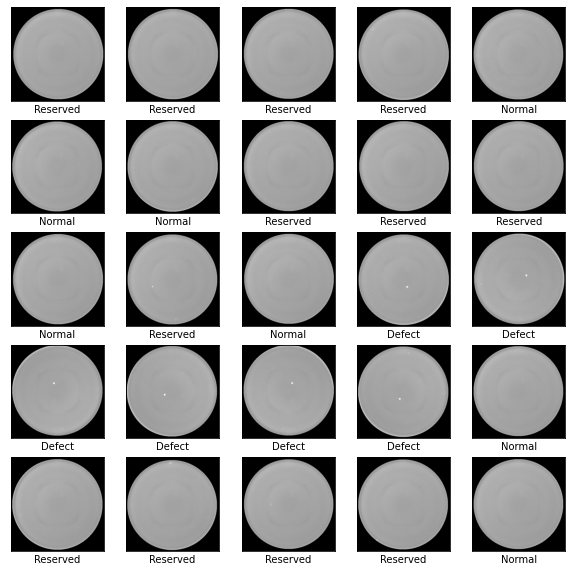

In [119]:
class_names = ["Normal", "Reserved", "Defect"]
pyplot.figure(figsize=(10,10))
for i in range(25):
    pyplot.subplot(5,5,i+1)
    pyplot.xticks([])
    pyplot.yticks([])
    pyplot.grid(False)
    pyplot.imshow(train_images[i], cmap="gray")
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    pyplot.xlabel(class_names[train_labels[i]])
pyplot.show()

In [127]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(images[0].shape[0], images[0].shape[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

'''
model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
'''
opt=tensorflow.keras.optimizers.Adagrad(lr=0.1) #SGD has too high of loss
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



history = model.fit(train_images, train_labels, batch_size=5, epochs=10,
                    validation_data=(test_images, test_labels))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 625, 620, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 312, 310, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 310, 308, 64)      18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 155, 154, 64)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 153, 152, 64)      36928     
_________________________________________________________________
flatten (Flatten)            (None, 1488384)           0         
_________________________________________________________________
dense (Dense)                (None, 64)               